# Import Libs

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import mode
import gc
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

/home/riley/covid_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

# Load Data

In [2]:
def gather_image_mask_paths(base_path):
    images_dir = os.path.join(base_path, "images")
    masks_dir = os.path.join(base_path, "masks")

    # Collect all valid image filenames - should only be png
    image_filenames = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg")) and f.split("/")[-1].split("-")[-1].split(".")[0].isnumeric() and 101 <= int(f.split("/")[-1].split("-")[-1].split(".")[0]) <= 600
    ]

    image_paths = []
    mask_paths = []

    for filename in image_filenames:
        image_path = os.path.join(images_dir, filename)
        mask_path = os.path.join(masks_dir, filename)  # same name in masks/
        image_paths.append(image_path)
        mask_paths.append(mask_path)

    return image_paths, mask_paths

In [3]:
def load_numpy_data(image_paths, mask_paths, labels):
    data = []
    for image_path, mask_path, label in tqdm(zip(image_paths, mask_paths, labels), total=len(image_paths)):
        with Image.open(image_path) as img:
            img_arr = np.array(img.convert("RGB"))  
        
        # Load mask
        with Image.open(mask_path) as msk:
            mask_arr = np.array(msk.convert("L")) # Assuming single channel. Will inspect if needed
        
        data.append((img_arr, mask_arr, label))
        
    return data

In [4]:
kaggle_cache_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
full_path = os.path.join(kaggle_cache_path, "COVID-19_Radiography_Dataset")
lung_opacity_path = os.path.join(full_path, "Lung_Opacity")
normal_path = os.path.join(full_path, "Normal")
viral_pneumonia_path = os.path.join(full_path, "Viral Pneumonia")
covid_path = os.path.join(full_path, "COVID")
lung_metadata = pd.read_excel(os.path.join(full_path, "Lung_Opacity.metadata.xlsx"))
normal_metadata = pd.read_excel(os.path.join(full_path, "Normal.metadata.xlsx"))
viral_pneumonia_metadata = pd.read_excel(os.path.join(full_path, "Viral Pneumonia.metadata.xlsx"))
covid_metadata = pd.read_excel(os.path.join(full_path, "COVID.metadata.xlsx"))

all_image_paths = []
all_mask_paths = []

covid_images, covid_masks = gather_image_mask_paths(covid_path)
all_image_paths.extend(covid_images)
all_mask_paths.extend(covid_masks)

normal_images, normal_masks = gather_image_mask_paths(normal_path)
all_image_paths.extend(normal_images)
all_mask_paths.extend(normal_masks)

vp_images, vp_masks = gather_image_mask_paths(viral_pneumonia_path)
all_image_paths.extend(vp_images)
all_mask_paths.extend(vp_masks)

lo_images, lo_masks = gather_image_mask_paths(lung_opacity_path)
all_image_paths.extend(lo_images)
all_mask_paths.extend(lo_masks)

print("Total images:", len(all_image_paths))

Total images: 2000


# Feature Extraction

### SVD

In [5]:
AC = []  # COVID images
AN = []  # Normal images
N = len(covid_images)

# Ensure grayscale and flatten
def flatten_image(img_path):
    with Image.open(img_path) as img:
        img_gray = img.convert("L")
        flat_img = np.array(img_gray, dtype=np.float64).ravel()
        return flat_img

for img_path in covid_images:
    AC.append(flatten_image(img_path))

# In SVD, we want each image to be a column
AC = np.array(AC).T  # shape: (m*n) x N

for img_path in normal_images:
    AN.append(flatten_image(img_path))

AN = np.array(AN).T  # shape: (m*n) x N

# Combine COVID and Normal images
A2 = np.hstack([AC, AN])  # Not yet mean-centered

# Average COVID, Normal, and overall - column-wise
avgC = np.mean(AC, axis=1)
avgN = np.mean(AN, axis=1)
avgAll = np.mean(A2, axis=1)

# Mean-center each image (for PCA using SVD)
# Create A by subtracting the overall average from each image
A = A2 - avgAll[:, np.newaxis]  # shape: (m*n, 2N)

# A = U S V^T
# U: (m*n) x (2N)
# S: (2N,) singular values - can be used to compute variance explained
# Vt: (2N) x (2N)
U, S, Vt = np.linalg.svd(A, full_matrices=False)
U.shape, S.shape, Vt.shape

((89401, 1000), (1000,), (1000, 1000))

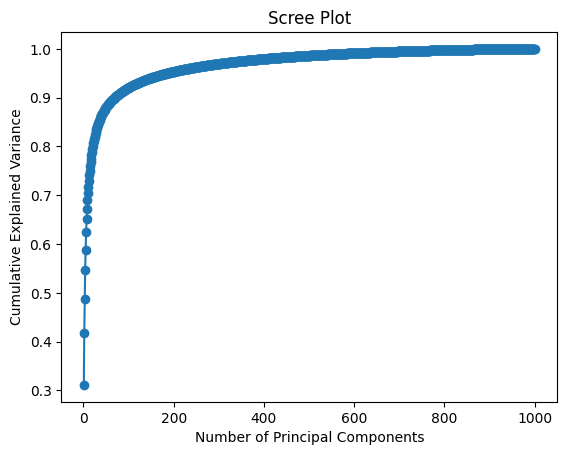

In [6]:
# Calculate the fraction of total variance each component explains
variance_explained = (S**2) / np.sum(S**2)
cumulative_variance = np.cumsum(variance_explained)
# Plot the scree plot
plt.figure()
plt.plot(range(1, len(S)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [7]:
threshold = 0.95
k_optimal = np.searchsorted(cumulative_variance, threshold) + 1
print(f"Number of PCs that reach {threshold*100}% variance: {k_optimal}")

Number of PCs that reach 95.0% variance: 185


In [8]:
# Principal components
Phi = U[:, :2*N].copy()  # keep all possible PCs
# Flip sign of the first principal component (optional)
Phi[:, 0] = -1.0 * Phi[:, 0]

# Project each image onto first 185 principal components
ARN = A[:, :N].T @ Phi[:, :185]
STAL = A[:, N:].T @ Phi[:, :185]

# Compute image-wise statistics on non-centered data A2
# shape of each will be (2N,) => one statistic per image
modes = mode(A2, axis=0).mode.flatten()     # from scipy.stats
means = np.mean(A2, axis=0)
medians = np.median(A2, axis=0)
stds = np.std(A2, axis=0)
ranges = np.ptp(A2, axis=0)  # peak-to-peak = max - min
maxvals = np.max(A2, axis=0)

# Construct label vector & final feature matrix
# 1 for COVID images, 0 for Normal
labels_covid = np.ones(N)
labels_normal = np.zeros(N)
labels = np.concatenate([labels_covid, labels_normal])  # shape (2N,)

# First 185 principal components stacked:
# ARN (N x 185) + STAL (N x 185) = (2N) x 185
PCs = np.vstack([ARN, STAL])  # shape (2N,5)

# Index for each image
x = np.arange(1, 2*N + 1)

# Combine into one NumPy array
# shapes: x -> (2N,), modes->(2N,), means->(2N,), ...
CRT_NNW_Data = np.column_stack([
    x,
    modes,
    means,
    medians,
    stds,
    PCs,        # 5 columns
    labels
])

columns = ["Image Index", "Mode", "Mean", "Median", "StdDev"]
columns.extend([f"PC{i}" for i in range(1, 186)])
columns.append("Label")

df = pd.DataFrame(CRT_NNW_Data,
                  columns=columns)

df.to_csv("CRT_NNW_Data.csv", index=False)
df.head()

,Image Index,Mode,Mean,Median,StdDev,PC1,PC2,PC3,PC4,PC5,...,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,Label
0,1.0,199.0,134.439358,139.0,51.015786,-996.951240,1828.940732,-1812.304837,3039.776450,-109.099317,...,345.576070,340.689980,-17.629883,-272.985895,25.950316,41.262583,65.206644,2.930163,-165.226976,1.0
1,2.0,0.0,118.084294,113.0,68.366987,3044.971712,-4111.437607,-1391.547402,-3675.304660,-191.926829,...,54.137133,-146.277005,-23.471718,-158.297680,299.544292,231.916164,321.096522,-65.160045,335.445262,1.0
2,3.0,162.0,159.990291,159.0,50.090400,-11767.318419,-3028.043015,4430.108949,-3640.233747,-4163.689015,...,243.676210,103.015431,-190.211606,220.304038,40.887884,-4.743933,-251.853712,-141.738517,-215.689567,1.0
3,4.0,1.0,91.309873,97.0,71.735164,3188.485191,-10480.102238,-12216.229416,-4764.768466,-4604.033914,...,-35.983171,132.427005,-115.194044,184.180673,-116.118553,165.950783,196.105945,96.134363,360.454412,1.0
4,5.0,207.0,146.895426,152.0,49.301507,-8958.987188,-2028.494383,-279.512869,-2072.242342,-238.701092,...,109.355462,102.104441,-84.798345,317.781280,-105.530154,-37.624478,-445.988026,-27.589756,-85.368506,1.0


In [9]:
X = df.drop(columns=["Image Index", "Label"])
y = df["Label"]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train)

(800, 800)

<Axes: >

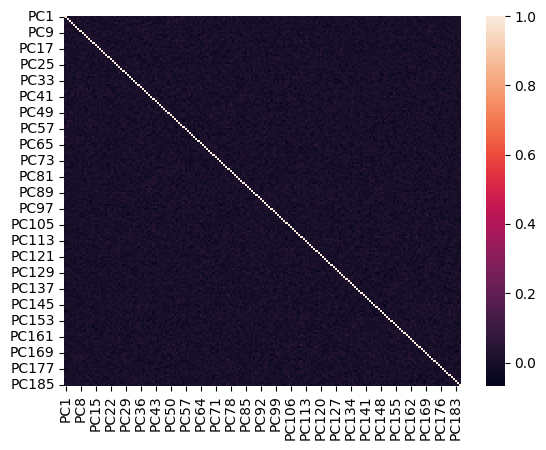

In [10]:
sns.heatmap(X_train[[x for x in X_train.columns if "PC" in x]].corr())

In [15]:
# PCA using sklearn
pca = PCA(n_components=3)
images_pca = pca.fit_transform(A)
images_pca.shape

(89401, 3)

In [16]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.27488591 0.09103844 0.07453067]


In [45]:
# Reconstruct back to original space
images_reconstructed = pca.inverse_transform(images_pca)

# Compute MSE (reconstruction error)
mse = mean_squared_error(A, images_reconstructed)
print("Reconstruction MSE:", mse)

Reconstruction MSE: 1066.876850126451


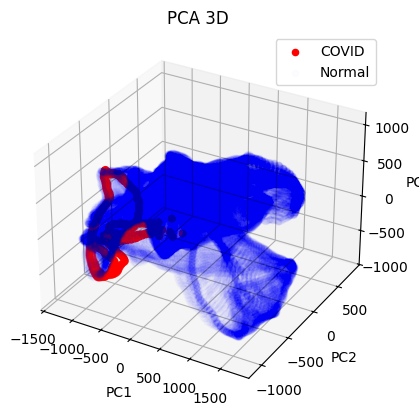

In [46]:
# plot PCA 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(images_pca[:N, 0], images_pca[:N, 1], images_pca[:N, 2], c='r', label='COVID')
ax.scatter(images_pca[N:, 0], images_pca[N:, 1], images_pca[N:, 2], c='b', alpha=0.01, label='Normal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D')
ax.legend()
plt.show()

In [48]:
pca = PCA(n_components=185)
images_pca = pca.fit_transform(A)
images_pca.shape

(89401, 185)

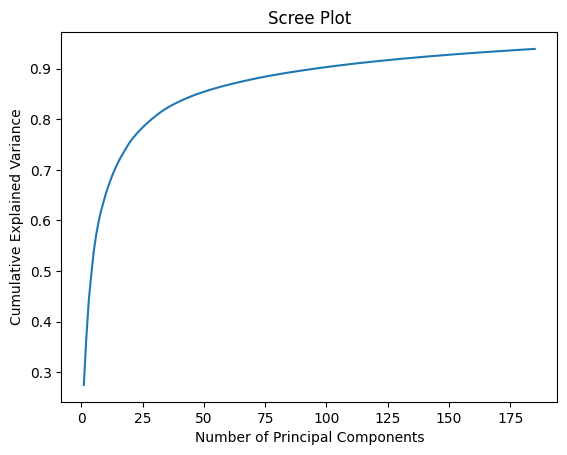

In [49]:
# scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [50]:
# Reconstruct back to original space
images_reconstructed = pca.inverse_transform(images_pca)

# Compute MSE (reconstruction error)
mse = mean_squared_error(A, images_reconstructed)
print("Reconstruction MSE:", mse)

Reconstruction MSE: 116.05335286178914


# Decision Tree

In [51]:
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_train, y_train)
print("Score:", clf.score(X_test, y_test))

Score: 0.99


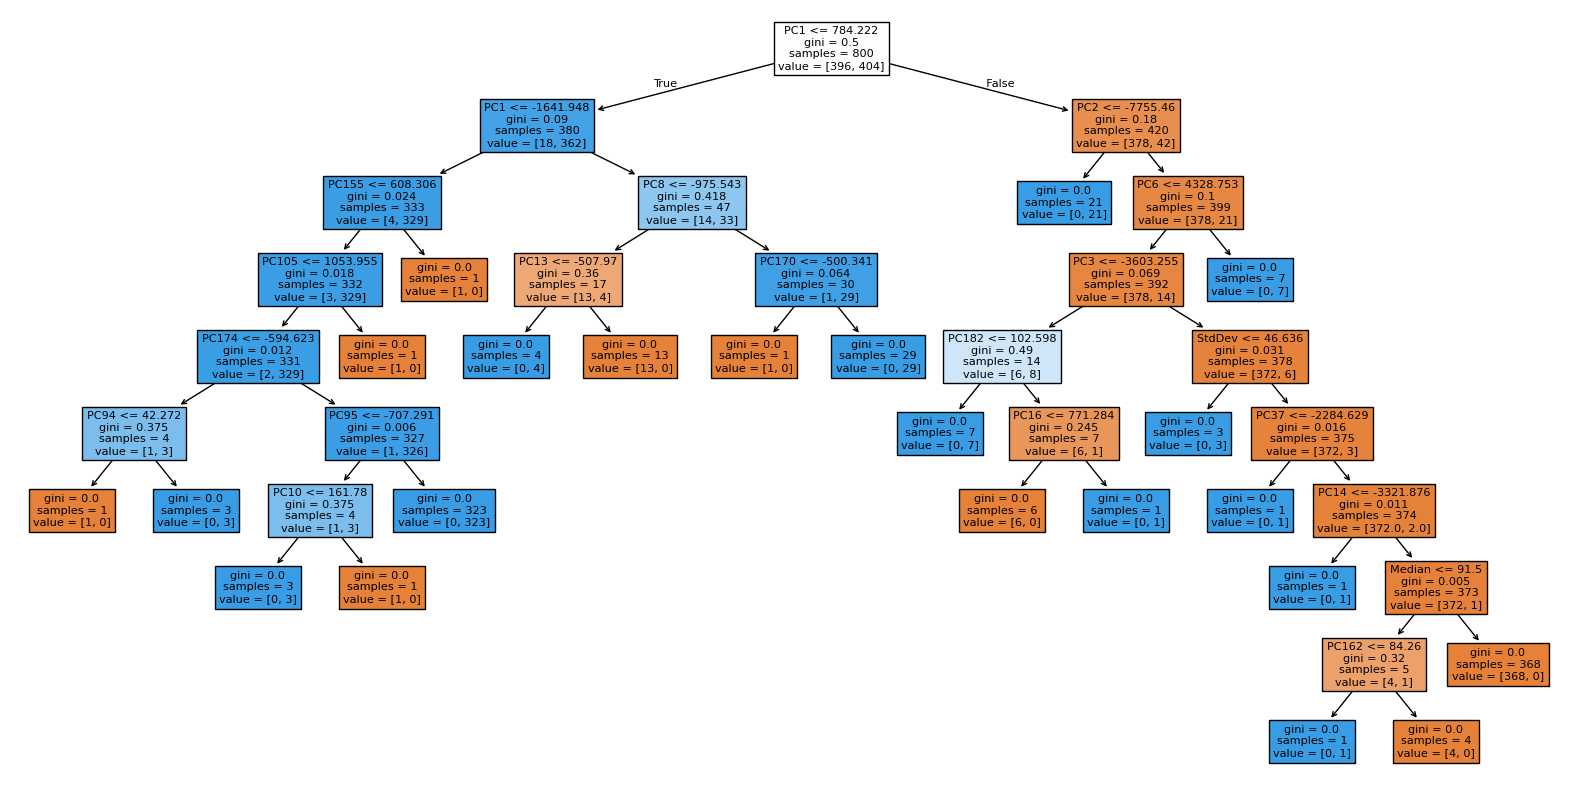

In [53]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns)
plt.savefig("baseline_decision_tree.png")
plt.show()

In [59]:
# train decision tree using KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
scores = []

for i, (train_index, val_index) in enumerate(kf.split(X_train_np)):
    print(f"Split {i}...")
    X_tr, X_val = X_train_np[train_index], X_train_np[val_index]
    y_tr, y_val = y_train_np[train_index], y_train_np[val_index]

    clf = DecisionTreeClassifier(random_state=42, max_depth=10)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Accuracy:", acc)
    scores.append(acc)

    del X_tr, X_val, y_tr, y_val, clf, y_pred
    gc.collect()

print("Average Accuracy:", np.mean(scores))

Split 0...
Accuracy: 0.9375
Split 1...
Accuracy: 0.9
Split 2...
Accuracy: 0.9625
Split 3...
Accuracy: 0.95
Split 4...
Accuracy: 0.925
Split 5...
Accuracy: 0.9375
Split 6...
Accuracy: 0.9
Split 7...
Accuracy: 0.925
Split 8...
Accuracy: 0.95
Split 9...
Accuracy: 0.9375
Average Accuracy: 0.9324999999999999


# Neural Network

In [62]:
X_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_tensor = torch.tensor(y_train_np, dtype=torch.float32)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = CustomDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch 0, Iteration 0, Loss: 45.68621826171875
Epoch 0, Iteration 10, Loss: 38.09501647949219
Epoch 0, Iteration 20, Loss: 53.16670227050781
Epoch 1, Iteration 0, Loss: 59.418155670166016
Epoch 1, Iteration 10, Loss: 54.559959411621094
Epoch 1, Iteration 20, Loss: 57.81230545043945
Epoch 2, Iteration 0, Loss: 42.77008819580078
Epoch 2, Iteration 10, Loss: 44.83271408081055
Epoch 2, Iteration 20, Loss: 67.44410705566406
Epoch 3, Iteration 0, Loss: 38.777244567871094
Epoch 3, Iteration 10, Loss: 47.35321807861328
Epoch 3, Iteration 20, Loss: 34.55736541748047
Epoch 4, Iteration 0, Loss: 54.23273468017578
Epoch 4, Iteration 10, Loss: 52.266632080078125
Epoch 4, Iteration 20, Loss: 53.14551544189453
Epoch 5, Iteration 0, Loss: 52.224693298339844
Epoch 5, Iteration 10, Loss: 46.96629333496094
Epoch 5, Iteration 20, Loss: 54.565162658691406
Epoch 6, Iteration 0, Loss: 40.8115234375
Epoch 6, Iteration 10, Loss: 38.60834503173828
Epoch 6, Iteration 20, Loss: 53.059268951416016
Epoch 7, Iteratio

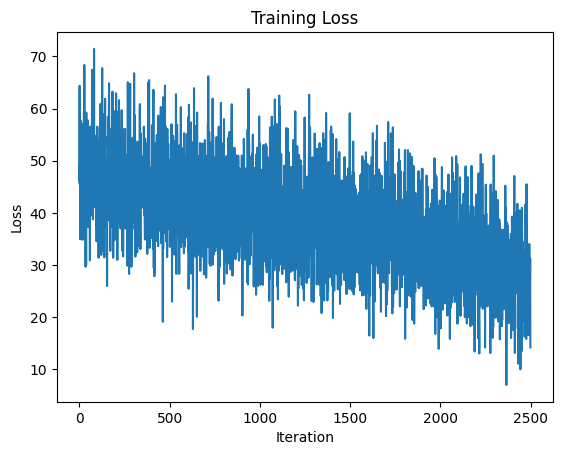

In [67]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(len(X.columns), 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
model = MLP().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()